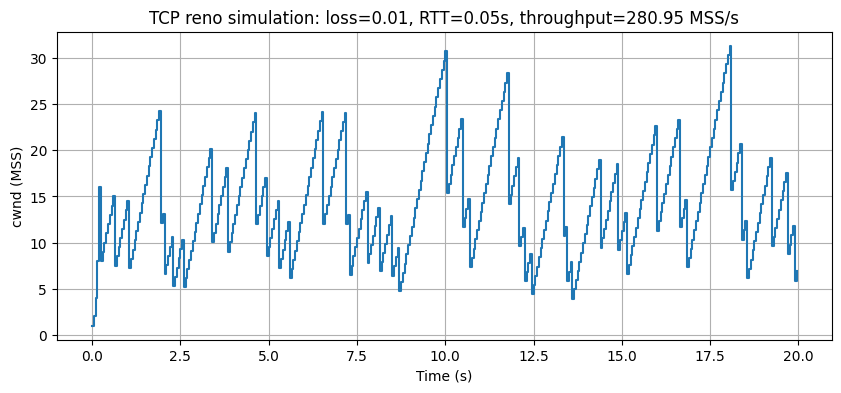

Sim done. Throughput (MSS/s): 280.950


In [1]:
# tcp_sim.py
# Simple discrete-time TCP congestion control simulator (Reno-like)
# Usage: python tcp_sim.py
import numpy as np
import matplotlib.pyplot as plt
import random

# --- Simulation parameters ---
RTT = 0.05               # seconds (50 ms)
sim_time = 20.0          # seconds
mss = 1.0                # normalized MSS (units)
loss_prob = 0.01         # per-packet loss probability (Bernoulli)
packets_per_seg = 1      # one packet per MSS in this model

# TCP behavior params
algorithm = "reno"       # "reno", "tahoe"
initial_cwnd = 1.0       # in MSS
ssthresh_init = 64.0     # in MSS
rto = 1.0                # simplified timeout (s)

# --- State variables ---
t = 0.0
cwnd = initial_cwnd
ssthresh = ssthresh_init
time_steps = []
cwnd_trace = []
sent_packets_total = 0
acked_packets_total = 0

# For throughput measurement
bytes_acked = 0.0

# Helper: simulate sending cwnd-sized window; return True if loss detected
def send_window(cwnd):
    # we model loss per packet with independent Bernoulli trial
    segs = int(max(1, round(cwnd / mss)))
    lost = False
    acks = 0
    for _ in range(segs):
        sent_packets_total_local = 1
        if random.random() < loss_prob:
            lost = True
        else:
            acks += 1
    return lost, acks

# Main loop: step in RTT-sized intervals
while t < sim_time:
    # record
    time_steps.append(t)
    cwnd_trace.append(cwnd)

    # determine phase: slow start or congestion avoidance
    in_slow_start = (cwnd < ssthresh)

    # send window, get ack/loss (this is simplification; real TCP tracks per-packet ACKs)
    lost, acks = send_window(cwnd)

    # update bytes acked
    bytes_acked += acks * mss

    # Simple Reno behavior
    if lost:
        # If Tahoe: go to slow start with cwnd = 1
        if algorithm == "tahoe":
            ssthresh = max(cwnd / 2.0, 2.0)
            cwnd = 1.0
        elif algorithm == "reno":
            # Reno: multiplicative decrease, enter congestion avoidance
            ssthresh = max(cwnd / 2.0, 2.0)
            cwnd = max(cwnd / 2.0, 1.0)
        # assume loss consumed this RTT
    else:
        # no loss -> increase cwnd
        if in_slow_start:
            cwnd = cwnd * 2.0  # exponential growth (per-RTT doubling)
        else:
            cwnd = cwnd + 1.0  # 1 MSS per RTT (additive increase)
    # Cap cwnd to a reasonable value to avoid runaway in this simple sim
    cwnd = min(cwnd, 1000.0)

    # advance time by one RTT
    t += RTT

# Convert to throughputs: bytes_acked / sim_time (in MSS units)
throughput = bytes_acked / sim_time

# Plot cwnd trace
plt.figure(figsize=(10,4))
plt.step(time_steps, cwnd_trace, where='post')
plt.xlabel("Time (s)")
plt.ylabel("cwnd (MSS)")
plt.title(f"TCP {algorithm} simulation: loss={loss_prob}, RTT={RTT}s, throughput={throughput:.2f} MSS/s")
plt.grid(True)
plt.show()

print(f"Sim done. Throughput (MSS/s): {throughput:.3f}")
